In [1]:
import numpy as np
from pathlib import Path
import json 

## Generate the skip trigram dataset
$$
\begin{array}{lll}
{[0] \ldots[1]} & \rightarrow & {[6]} \\
{[0] \ldots[2]} & \rightarrow & {[7]} \\
{[0] \ldots[3]} & \rightarrow & {[8]} \\
{[0] \ldots[4]} & \rightarrow & {[9]} \\
{[0] \ldots[5]} & \rightarrow & {[10]}
\end{array}
$$

In [10]:
import numpy as np

num_examples = 100000
subseq_length = 3
total_length = 7
max_digit = 8

def generate_sequences(N, L, total_len):
    sequences = []
    labels = []

    for _ in range(N):
        # Generate a random sequence
        sequence = np.random.randint(1, max_digit+1, total_len)

        # Choose a random start position for the subsequence
        start_pos = np.random.randint(0, total_len - L)

        # Generate the subsequence
        subsequence = np.concatenate(([0], np.random.randint(1, max_digit-4, L-2), np.random.randint(1, max_digit-4, 1)))

        # Insert the subsequence into the sequence
        sequence[start_pos:start_pos + L] = subsequence
        
        # Prepend max_digit+1 to sequence as a special token
        sequence = np.concatenate(([max_digit+1], sequence))

        # Create a label that is +5 of the final number of the subsequence
        label = subsequence[-1] + 5

        sequences.append(sequence)
        labels.append(label)

    return sequences, labels

seqs, labels = generate_sequences(num_examples, subseq_length, total_length)
_ = [print(seq, labels[i]) for i, seq in enumerate(seqs) if i < 10]


[9 2 2 0 1 2 4 4] 7
[9 0 1 2 8 4 3 5] 7
[9 3 0 2 3 1 5 3] 8
[9 0 1 3 2 6 5 2] 8
[9 7 0 2 1 7 7 1] 6
[9 4 0 3 3 1 2 4] 8
[9 3 4 0 1 3 7 1] 8
[9 3 0 1 3 6 8 2] 8
[9 1 8 0 3 3 2 8] 8
[9 6 0 1 2 8 6 2] 7


In [3]:
# # make the entire dataset just the first example

# seqs = np.array(seqs[:1]).repeat(10000, axis=0)
# labels = np.array(labels[:1]).repeat(10000, axis=0)

In [11]:
from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch

retrain = True
data_dir = Path('data')
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cfg = HookedTransformerConfig(
    n_layers = 1,
    d_model  = 4*16,
    d_head   = 16,
    n_heads  = 4,
    d_vocab  = max_digit+1,
    n_ctx    = total_length+1,
    attn_only= False,
    act_fn   = 'relu',
    device   = device,
)

#! do they use causal masks?

# Search for model with matching cfg
loaded_model = False
if not retrain:
    for model_cfg_path in data_dir.glob('**/cfg.json'):
        with open(model_cfg_path) as f:
            model_cfg = json.load(f)
        if model_cfg == cfg.__dict__:
            print(f'Found matching model at {model_cfg_path.parent}')
            loaded_model = True
            state_dict = torch.load(model_cfg_path.parent / 'model.pt', map_location=device)
            break

Training:  95%|█████████▌| 1907584/2000000 [03:37<00:10, 9134.57seqs/s, loss=2.23]

In [23]:
from torch import nn
import math
# Train a simple 1 layer model
from fancy_einsum import einsum

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x.transpose(0, 1) # B, S -> S, B
        x = x + self.pe[:x.size(0)]
        x = x.transpose(0, 1) # S, B -> B, S
        return x

class SimpleTransformer(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # self.embedding = torch.eye(cfg.d_vocab) 
        # right apppend zero columns up to d_model
        # self.embedding = torch.nn.Parameter(torch.cat([self.embedding, torch.zeros(cfg.d_vocab, cfg.d_model - cfg.d_vocab)], dim=1), requires_grad=False)
        self.embedding = torch.nn.Embedding(cfg.d_vocab+1, cfg.d_model)

        self.pos_encod = PositionalEncoding(cfg.d_model, max_len=cfg.n_ctx)

        if cfg.attn_only:
            self.layer = torch.nn.MultiheadAttention(cfg.d_model, cfg.n_heads)
        else:
            self.layer = torch.nn.TransformerEncoderLayer(cfg.d_model, cfg.n_heads, norm_first=True, batch_first=True)
        
        self.unembedding = torch.nn.Linear(cfg.d_model, 3)#cfg.d_vocab)
        
    def forward(self, x):
        # embed
        # x = einsum('d_vocab d_embed, batch seq d_vocab -> batch seq d_embed', self.embedding, x)
        x = self.embedding(x)
        x = self.pos_encod(x)
        
        # attend residually
        x = self.layer(x)
        
        # unembed with the embedding
        # x = einsum('d_vocab d_embed, batch seq d_embed -> batch seq d_vocab', self.embedding, x)

        # x[:].mean(dim=1)
        # unembedding MLP?
        x = self.unembedding(x[:,0])
        return x

model = SimpleTransformer(cfg).to(device)
# tokenize by using onehot
sample_in = torch.tensor(seqs[0], device=device).unsqueeze(0)
# print(sample_in.shape)

# sample_in = torch.nn.functional.one_hot(sample_in, max_digit+1).long().to(device)
sample_in = sample_in.repeat(3, 1)


model(sample_in).shape

torch.Size([3, 3])

In [20]:
# # test embedding
# a = seqs[0]
# a_tok = torch.nn.functional.one_hot(torch.tensor(a), max_digit+1).float().to(device)
# a_embed = einsum('d_vocab d_embed, seq d_vocab -> seq d_embed', model.embedding, a_tok)
# a_unembed = einsum('d_vocab d_embed, seq d_embed -> seq d_vocab', model.embedding, a_embed)
# # print(a_tok,'\n', a_unembed)

# print(a, a_unembed.argmax(dim=-1))

In [28]:
# Train in batches
# from csv import writer
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

batch_size = 128
num_epochs = 10

model = SimpleTransformer(cfg).to(device)
if loaded_model:
    model.load_state_dict(state_dict)
else:
    # Add progress bar with loss 
    pbar = tqdm(total=len(seqs)*num_epochs, desc='Training', unit='seqs')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # pbar = tqdm(total=len(seqs)*num_epochs, desc='Training', unit='seqs')

    step = 0
    for epoch in range(num_epochs):
        for i in range(0, len(seqs), batch_size):
            end_idx = min(i+batch_size, len(seqs))
            batch_data, batch_labels = seqs[i:end_idx], labels[i:end_idx]
            batch_data = torch.tensor(batch_data).to(device).long()
            # batch_data = torch.nn.functional.one_hot(batch_data, max_digit+1).float()
            batch_labels = torch.tensor(batch_labels).to(device)
            batch_labels = batch_labels - 6

            pred = model(batch_data)
            # pred = torch.nn.functional.log_softmax(pred, dim=-1) 
            # print(pred.shape)
            # batch_labels = torch.nn.functional.one_hot(batch_labels, 3).float()
            # batch_labels = 
            # loss = torch.nn.functional.mse_loss(pred, batch_labels)
            # loss = torch.nn.functional.nll_loss(pred, batch_labels)
            loss = torch.nn.functional.cross_entropy(pred, batch_labels)

            # log to tensorboard
            writer.add_scalar('Loss/train', loss.item(), step)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.update(batch_size)
            pbar.set_postfix(loss=loss.item())
            step += 1

    # Save model and cfg in a directory 
    dir_name = Path('data/model_' + str(len(list(Path('./data/').glob('model_*')))))
    dir_name.mkdir(exist_ok=True)
    torch.save(model.state_dict(), dir_name/'model.pt')
    with open(dir_name/'cfg.json', 'w') as f:
        json.dump(cfg.__dict__, f)

Training:   0%|          | 1280/2000000 [00:00<03:51, 8627.46seqs/s, loss=1.08]

Training: 2001920seqs [03:31, 9332.08seqs/s, loss=0.0824]                            

In [29]:
print(batch_data.shape)
pred = model(batch_data).argmax(dim=-1)
labels = batch_labels
print(pred == labels)

torch.Size([32, 8])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])


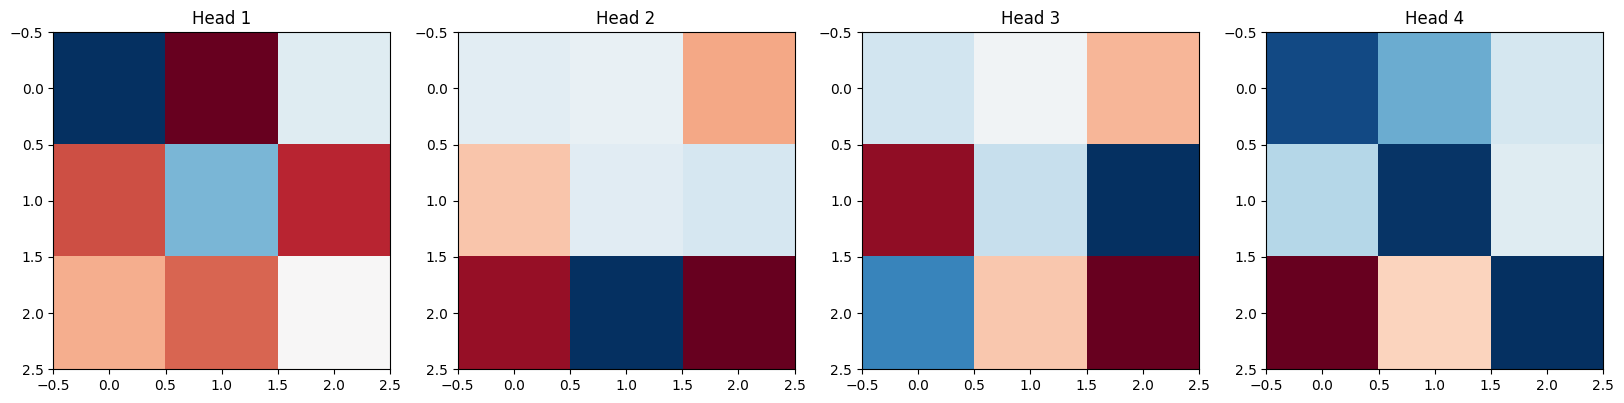

In [41]:
# print(list(model.layer.parameters()))
import matplotlib.pyplot as plt
qkv = model.layer.self_attn.in_proj_weight
q, k, v = qkv.chunk(3, dim=0)
qk = k.T@q

# decompose by head
f, ax = plt.subplots(1, cfg.n_heads, figsize=(20, 5))
for i in range(cfg.n_heads):
    q_head = q[i*cfg.d_model//cfg.n_heads:(i+1)*cfg.d_model//cfg.n_heads]
    k_head = k[i*cfg.d_model//cfg.n_heads:(i+1)*cfg.d_model//cfg.n_heads]
    # attention map for tokens 1 through 5 to token 1
    qk_head = k_head.T@q_head
    # unembedded = model.embedding.weight@qk_head@model.embedding.weight.T
    # unembedded = qk_head
    unembedded = model.unembedding.weight@qk_head@model.unembedding.weight.T
    ax[i].imshow(unembedded.detach().cpu().numpy(), cmap='RdBu')
    ax[i].set_title(f'Head {i+1}')


# qk = einsum('d_model d_model, d_model d_model -> d_model d_model', q, k)

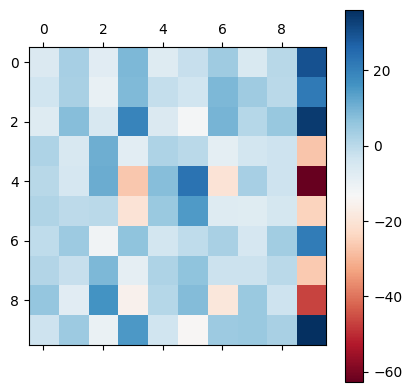

In [34]:
unembedded = model.embedding.weight@qk@model.embedding.weight.T
from matplotlib import pyplot as plt
f = plt.matshow(unembedded.detach().cpu().numpy(), cmap='RdBu')
cbar = plt.colorbar(f)

k